In [1]:
import seaborn as sns
import os.path as path
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, accuracy_score,precision_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
import eli5
import pickle

Using TensorFlow backend.


In [2]:
data_dir = "./ember2018/"

In [3]:
fn_X_sample = path.join(data_dir, 'X_sample-100K.dat')
fn_y_sample = path.join(data_dir, 'y_sample-100K.dat')

In [4]:
X = np.memmap(fn_X_sample, dtype='float32', mode='r', shape=(100000, 2381))
y = np.memmap(fn_y_sample, dtype='float32', mode='r', shape=(100000,))

In [5]:
X.shape, y.shape

((100000, 2381), (100000,))

In [6]:
# baseline score
y.mean()

0.5

In [7]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

CPU times: user 214 ms, sys: 407 ms, total: 621 ms
Wall time: 35.6 s


In [8]:
y_train.mean(), y_test.mean()

(0.5, 0.5)

### Standarize the X_train and X_test

In [9]:
ss = StandardScaler()

In [10]:
%%time
ss.fit(X_train)

CPU times: user 2.07 s, sys: 678 ms, total: 2.75 s
Wall time: 2.75 s


StandardScaler(copy=True, with_mean=True, with_std=True)

In [11]:
%%time
X_train = ss.transform(X_train)

CPU times: user 1.19 s, sys: 188 ms, total: 1.37 s
Wall time: 1.37 s


In [12]:
%%time
X_test = ss.transform(X_test)

CPU times: user 293 ms, sys: 52.1 ms, total: 346 ms
Wall time: 344 ms


In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80000, 2381), (20000, 2381), (80000,), (20000,))

# PCA to reduce the dataset's dimension

In [14]:
# To run PCA and keep 95% of the variance
pca = PCA(n_components=0.95, whiten=True)

In [15]:
%%time
X_train_pca = pca.fit_transform(X_train)

CPU times: user 1min 24s, sys: 4.5 s, total: 1min 28s
Wall time: 24.8 s


In [16]:
# Show results
print('Original number of features:', X_train.shape[1])
print('Reduced number of features:', X_train_pca.shape[1])

Original number of features: 2381
Reduced number of features: 1183


In [17]:
%%time
X_test_pca = pca.transform(X_test)

CPU times: user 2.45 s, sys: 229 ms, total: 2.68 s
Wall time: 777 ms


In [18]:
pca.components_.shape

(1183, 2381)

In [19]:
%%time
type(X_train_pca), type(X_test_pca), type(X_train), type(X_test)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.44 µs


(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

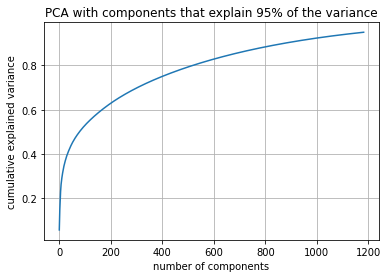

In [20]:
plt.title('PCA with components that explain 95% of the variance')
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid()

# Model evaluation function

In [21]:
def model_evaluation(pipeline_in):
    pipeline_in.fit(X_train_pca,y_train) # training the model
    pipeline_in.score(X_test_pca,y_test) 
    y_hat_this = pipeline_in.predict(X_test_pca)
    y_hat_pr_this = pipeline_in.predict_proba(X_test_pca)
    print(f'Accuration score with y_test & y_pred: {accuracy_score(y_test,y_hat_this)}')
    print('----------------------------------------')
    print('Classification Report')
    print('----------------------------------------')
    print(classification_report(y_test,y_hat_this))
    
    print('----------------------------------------')
    print('Confusion Matrix')
    print('----------------------------------------')
    conmat = np.array(confusion_matrix(y_test,y_hat_this,labels=[1,0]))
    confusion = pd.DataFrame(conmat, index=['is_malware', 'is_benign'],
                         columns=['predicted_malware','predicted_benign'])
    print(confusion)
    
    fpr, tpr, th = roc_curve(y_test, y_hat_pr_this[:,1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=[5,5])
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver operating characteristic', fontsize=12)
    plt.legend(loc="lower right")
    plt.show()
    
    #display(eli5.explain_weights(pipeline_in))

# Experiment 1 - LogisticRegression

In [22]:
%%time
# Creating the pipeline
pl_e1 = make_pipeline(LogisticRegression())
#pl_e1 = make_pipeline(TfidfVectorizer(), LogisticRegression())
lg_params = {'logisticregression__C':[1.0, 0.01],
            'logisticregression__solver':['liblinear']}
lg_grid = GridSearchCV(pl_e1, param_grid=lg_params, cv=5, scoring="accuracy", n_jobs=-1)
lg_grid.fit(X_train_pca, y_train)

CPU times: user 2min 26s, sys: 1.1 s, total: 2min 27s
Wall time: 7min 12s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'logisticregression__C': [1.0, 0.01], 'logisticregression__solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [23]:
%%time
lg_best = lg_grid.best_score_
print(lg_grid.best_params_)
print(lg_grid.best_score_)
pl_e1.set_params(**lg_grid.best_params_)

{'logisticregression__C': 1.0, 'logisticregression__solver': 'liblinear'}
0.914575
CPU times: user 703 µs, sys: 0 ns, total: 703 µs
Wall time: 551 µs


Pipeline(memory=None,
     steps=[('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))])

Accuration score with y_test & y_pred: 0.9134
----------------------------------------
Classification Report
----------------------------------------
              precision    recall  f1-score   support

         0.0       0.91      0.92      0.91     10000
         1.0       0.92      0.91      0.91     10000

   micro avg       0.91      0.91      0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000

----------------------------------------
Confusion Matrix
----------------------------------------
            predicted_malware  predicted_benign
is_malware               9065               935
is_benign                 797              9203


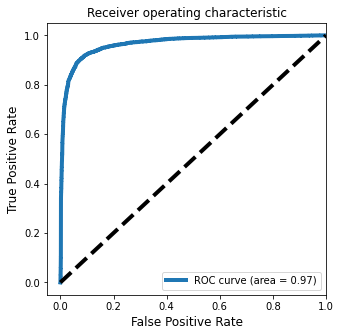

In [24]:
model_evaluation(pl_e1)

# Experiment 2: KNN

In [22]:
pl_e2 = make_pipeline(KNeighborsClassifier())

lg_params2 = {'kneighborsclassifier__n_neighbors': [3, 5, 7, 9],
             'kneighborsclassifier__weights': ['uniform', 'distance'],
             'kneighborsclassifier__metric': ['euclidean']}
lg_grid2 = GridSearchCV(pl_e2, param_grid=lg_params2, cv=5, scoring="accuracy", n_jobs=-1)
lg_grid2.fit(X_train_pca, y_train)

KeyboardInterrupt: 

In [ ]:
knn_best = lg_grid2.best_score_
print(lg_grid2.best_params_)
print(lg_grid2.best_score_)
pl_e2.set_params(**lg_grid2.best_params_)

In [ ]:
model_evaluation(pl_e2)